<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


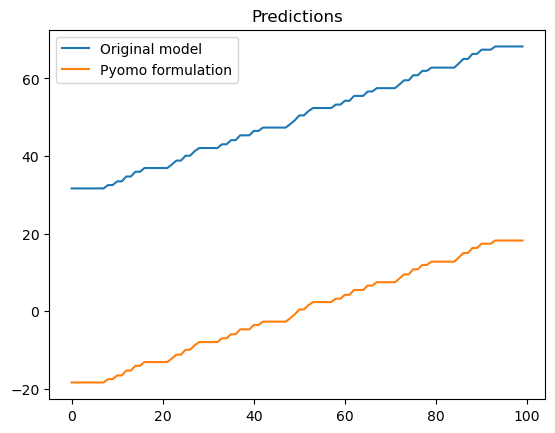

In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import pyomo.environ as pyo
from omlt import OmltBlock
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel
import matplotlib.pyplot as plt

# Train simple model
x = np.array(range(101)).reshape(-1, 1)
y = np.array(range(101))

model_gbt = GradientBoostingRegressor(n_estimators=5)
model_gbt.fit(x, y)

# Get predictions directly from model
y_pred = model_gbt.predict(np.array(range(100)).reshape(-1, 1))

# Get predictions from pyomo formulation
y_opt = []
for i in range(100):
    initial_type = [('float_input', FloatTensorType([None, 1]))]
    model_onx = convert_sklearn(model_gbt, initial_types=initial_type)

    m = pyo.ConcreteModel('Random GradientBoostingRegressor')

    m.gbt = OmltBlock()
    # Forces the input to equal the input from the previous prediction
    input_bounds = {0: (i, i)}
    gbt_model = GradientBoostedTreeModel(
        model_onx, scaled_input_bounds=input_bounds)

    formulation = GBTBigMFormulation(gbt_model)
    m.gbt.build_formulation(formulation)

    m.obj = pyo.Objective(expr=0)

    solver = pyo.SolverFactory("gurobi", solver_io="python")
    status = solver.solve(m, tee=False)

    y_opt.append(m.gbt.outputs[0].value)

# Plot predictions
plt.plot(y_pred)
plt.plot(y_opt)
plt.title('Predictions')
plt.legend(['Original model', 'Pyomo formulation'])
